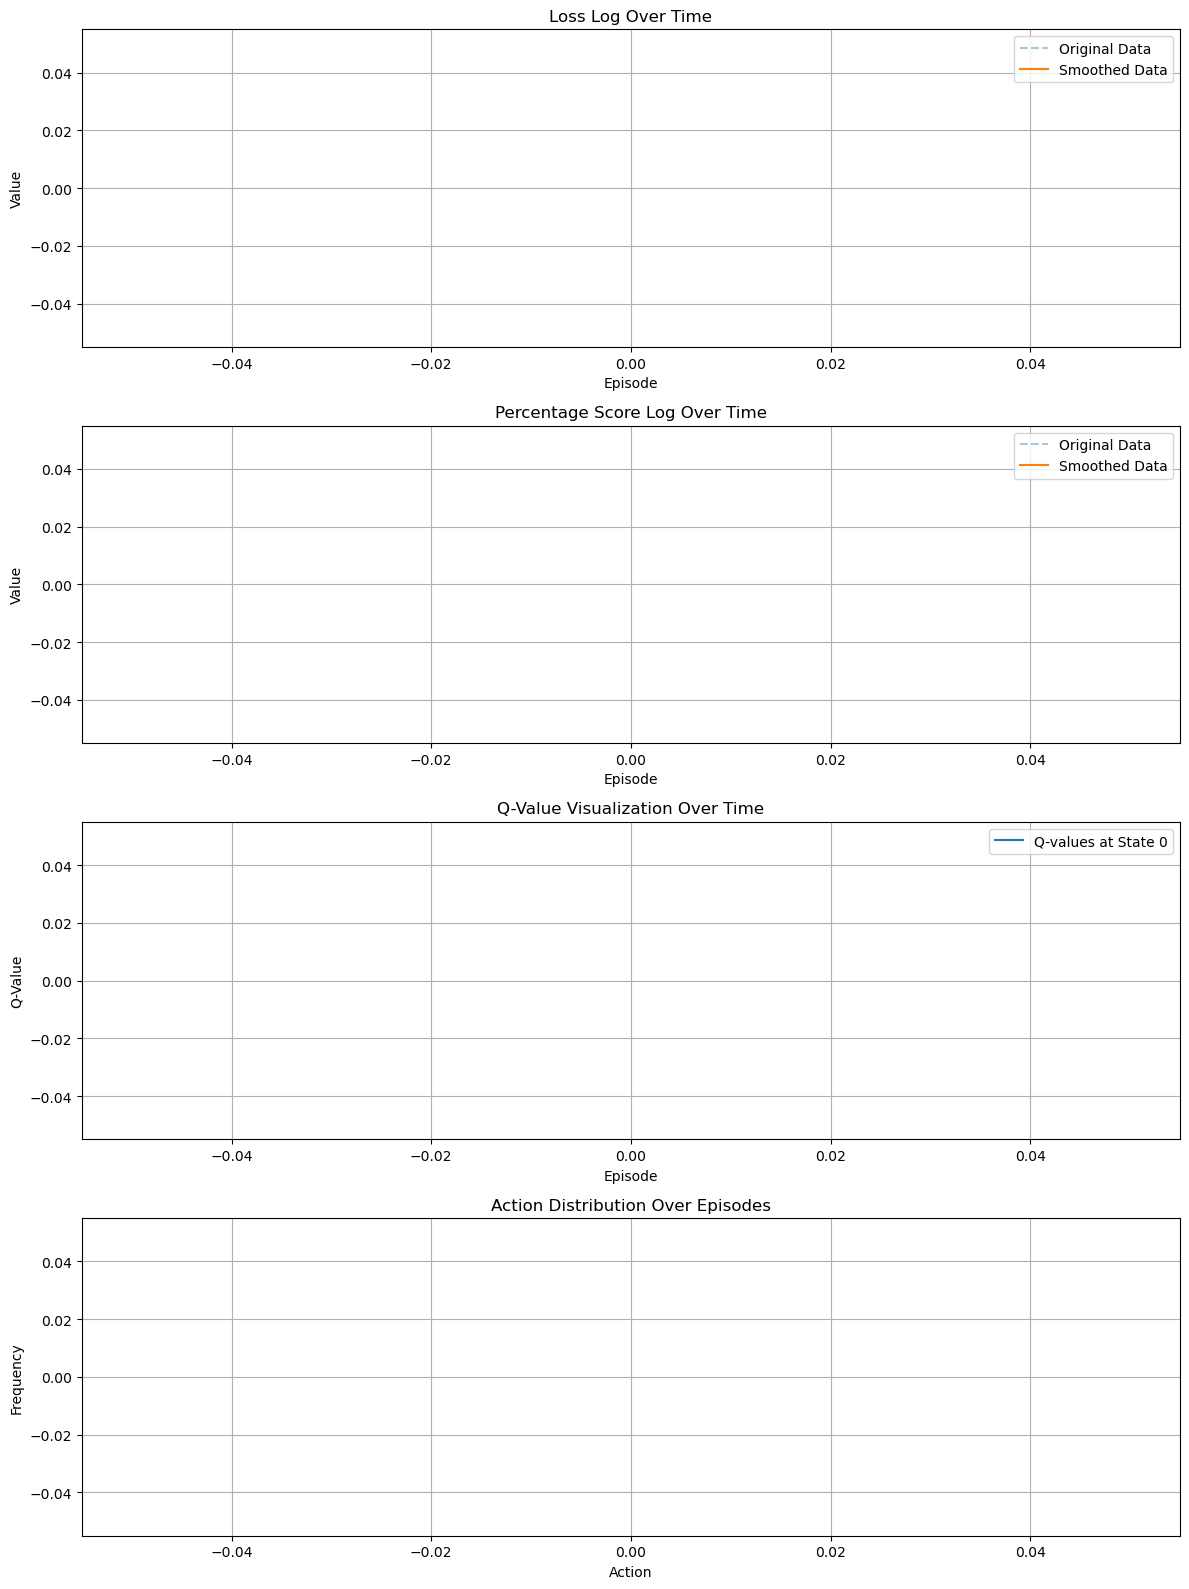

UnboundLocalError: local variable 'state_sample' referenced before assignment

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt

def smooth_data(data, window_percent):
    window_size = int(len(data) * window_percent)
    window_size = max(1, window_size)
    smoothed = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return window_size, smoothed


def plot_live(loss_log, perc_score_log, q_values_log, action_distribution_log):
    print(f"loss:{loss_log[-1]}, score:{perc_score_log[-1]}%")
    # Smooth data
    window_size_ll, smoothed_data_ll = smooth_data(loss_log, 0.05)
    window_size_ps, smoothed_data_ps = smooth_data(perc_score_log, 0.05)

    # Plotting
    clear_output(wait=True)
    fig, axs = plt.subplots(4, 1, figsize=(12, 16))

    # Loss Log Graph
    axs[0].plot(loss_log, label='Original Data', linestyle='--', alpha=0.4)
    axs[0].plot(np.arange(window_size_ll - 1, len(loss_log)), smoothed_data_ll, label='Smoothed Data')
    axs[0].set_title("Loss Log Over Time")
    axs[0].set_ylabel('Value')
    axs[0].set_xlabel('Episode')
    axs[0].grid(True)
    axs[0].legend()

    # Human Score Log Graph
    axs[1].plot(perc_score_log, label='Original Data', linestyle='--', alpha=0.4)
    axs[1].plot(np.arange(window_size_ps - 1, len(perc_score_log)), smoothed_data_ps, label='Smoothed Data')
    axs[1].set_title("Percentage Score Log Over Time")
    axs[1].set_ylabel('Value')
    axs[1].set_xlabel('Episode')
    axs[1].grid(True)
    axs[1].legend()

    # Q-Value Visualization
    for q_values in q_values_log:
        axs[2].plot(q_values, label=f'Q-values at State {q_values_log.index(q_values)}')
    axs[2].set_title("Q-Value Visualization Over Time")
    axs[2].set_ylabel('Q-Value')
    axs[2].set_xlabel('Episode')
    axs[2].grid(True)
    axs[2].legend()

    # Action Distribution Plot
    axs[3].hist(action_distribution_log, bins=range(len(action_distribution_log)), alpha=0.7)
    axs[3].set_title("Action Distribution Over Episodes")
    axs[3].set_xlabel('Action')
    axs[3].set_ylabel('Frequency')
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()

# Create environment
env = gym.make('Pendulum-v1')

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

# Hyperparameters
learning_rate = 0.001
gamma = 0.95  # discount rate
epsilon = 1.0  # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
memory_size = 1000000


# DQN Model
def build_model():
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate))
    return model

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# Main DQN algorithm
model = build_model()
memory = ReplayBuffer(memory_size)
perc_score_log = [0]
loss_log = [0]  # To store loss values
q_values_log = [0]  # To store Q-values for specific states
action_distribution_log = [0] 

def train_dqn(model, memory, loss_function):
    global epsilon
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    done = False
    step = 0
    while not done:
        plot_live(loss_log, perc_score_log, q_values_log, action_distribution_log)

        if np.random.rand() <= epsilon:
            action = np.random.uniform(env.action_space.low, env.action_space.high, size=env.action_space.shape)
        else:
            action = model.predict(state)[0]

        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        memory.add(state, action, reward, next_state, done)
        state = next_state

        if len(memory.buffer) > batch_size:
            minibatch = memory.sample(batch_size)
            for state_sample, action_sample, reward_sample, next_state_sample, done_sample in minibatch:
                future_reward = 0
                if not done_sample:
                    future_reward = np.amax(model.predict(next_state_sample)[0])
                updated_q_values = reward_sample + gamma * future_reward

        with tf.GradientTape() as tape:
            q_values = model(state_sample)
            loss = loss_function(updated_q_values, q_values)
            loss_log.append(loss.numpy())  # Appending the numpy value of the loss

        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        step += 1
        if step >= 500:  # Adjust according to your maximum steps per episode
            break

# Define a loss function
loss_function = tf.keras.losses.MeanSquaredError()

# Train the model
train_dqn(model, memory, loss_function)
